In [ ]:
import warnings
warnings.filterwarnings('ignore')

from IPython.display import Image

# Feature Engineering

In this notebook, we will create additional features to not only **predict using** the station but also the variable of **time**.

In [ ]:
# Notebook libraries:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
import math

import datetime
import holidays 

First, let's import the data previously cleaned:

In [ ]:
stations = pd.read_pickle('../data/stations.pkl')
df_ml = pd.read_pickle('../data/data_ml.pkl')
df_ml.head()

,station_id,station_status_last_reported,lat,lon,true_bike_capacity,capacity,percentage_bikes_available
14,385,2021-08-25 12:09:38-04:00,40.757973,-73.966033,27,29,0.111111
16,385,2021-11-30 06:45:05-05:00,40.757973,-73.966033,29,29,0.241379
18,385,2021-11-20 17:54:08-05:00,40.757973,-73.966033,28,29,0.035714
21,385,2021-10-07 22:41:46-04:00,40.757973,-73.966033,25,29,0.0
42,385,2021-03-23 21:41:03-04:00,40.757973,-73.966033,28,29,0.178571


In [ ]:
stations.head()

,station_id,station_name,lat,lon,region_id,capacity,count
0,259,South St & Whitehall St,40.701221,-74.012342,71,39,48656
1,303,Mercer St & Spring St,40.723627,-73.999496,71,67,65342
2,3069,Lorimer St & Broadway,40.704118,-73.948186,71,29,11213
3,3113,Greenpoint Ave & Manhattan Ave,40.730260,-73.953940,71,27,40306
4,3357,W 106 St & Amsterdam Ave,40.800836,-73.966449,71,35,37573


## TIME VARIABLE (PER STATION)

Let's grab just one station, say, **South St & Whitehall St** (the station if we're coming back or arriving to a Ferry).

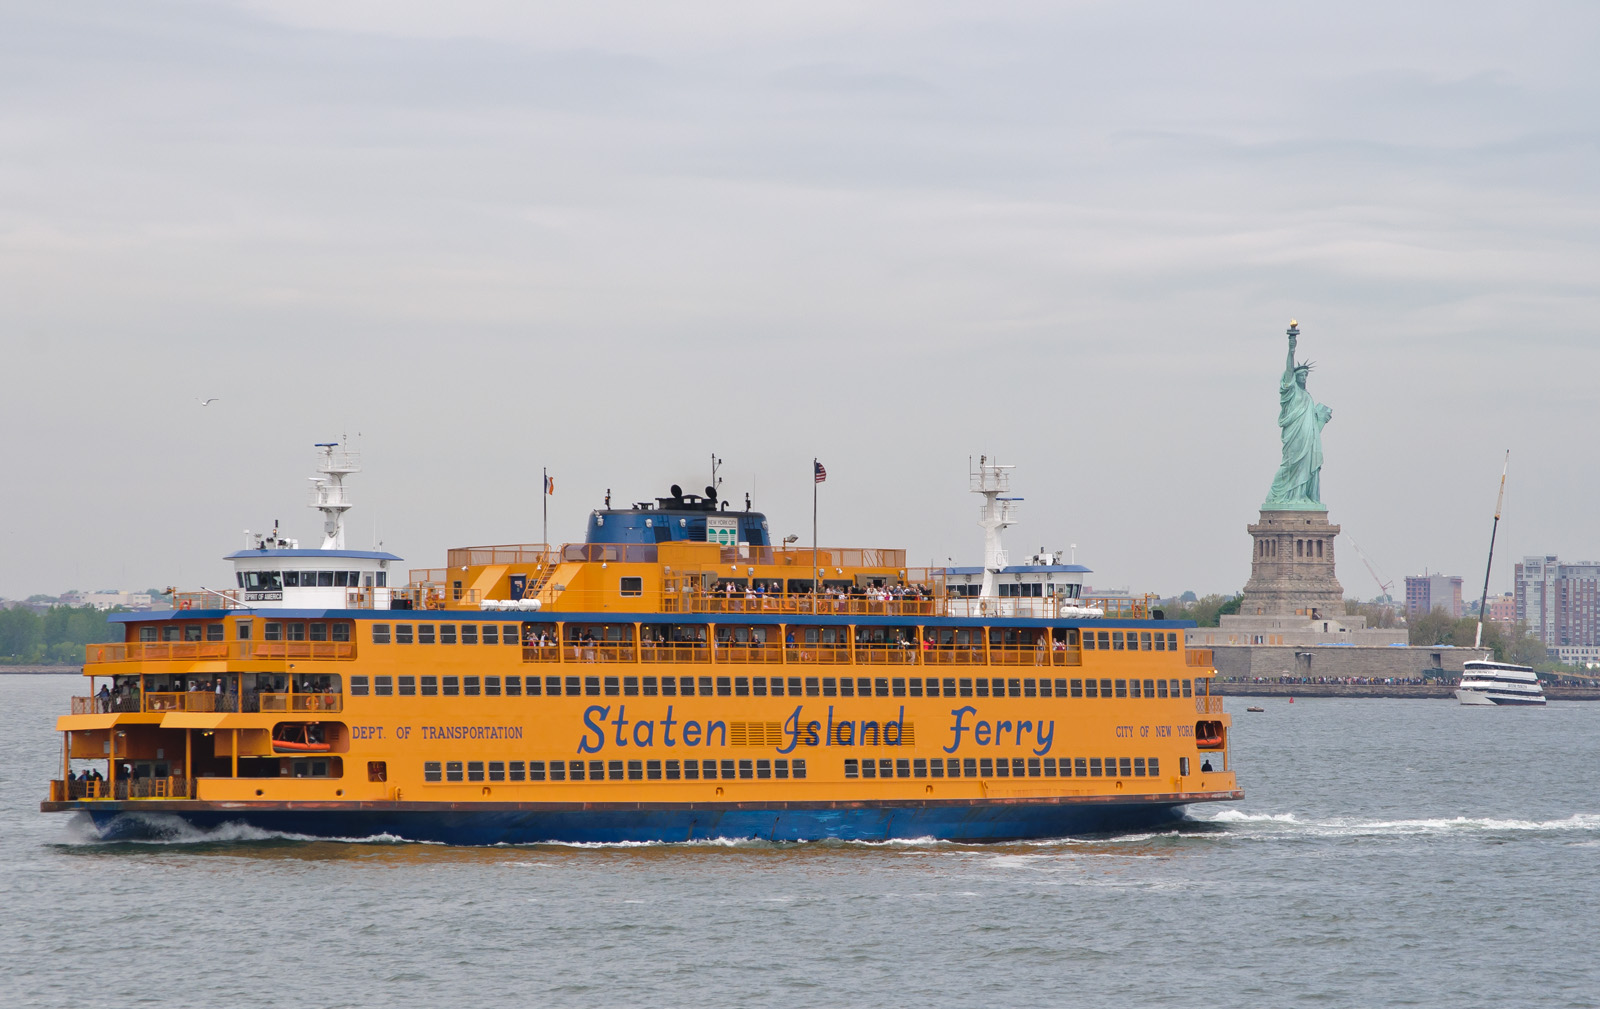

In [ ]:
df_ferry = df_ml.query("station_id=='259'").copy()

Now, let's reformat our timestamp variable to have 5-minute increments between each observation, taking the previous observation if time is not found (these steps are suggested by the author of the data).

In [ ]:
# Sort the DataFrame by the timestamp column
df_ferry = df_ferry.set_index("station_status_last_reported").sort_index()

# Format:
df_ferry = df_ferry.resample("5T").last()
df_ferry = df_ferry.fillna(method="ffill")

In [ ]:
df_ferry[['percentage_bikes_available']].head()

,percentage_bikes_available
station_status_last_reported,
2020-11-30 20:55:00-05:00,0.948718
2020-11-30 21:00:00-05:00,0.948718
2020-11-30 21:05:00-05:00,0.948718
2020-11-30 21:10:00-05:00,0.948718
2020-11-30 21:15:00-05:00,0.948718


Let's plot the bike/dock availability for that station over a time span of two weeks (remember bike + dock percentage availability are complementary and will always sum up to 1):

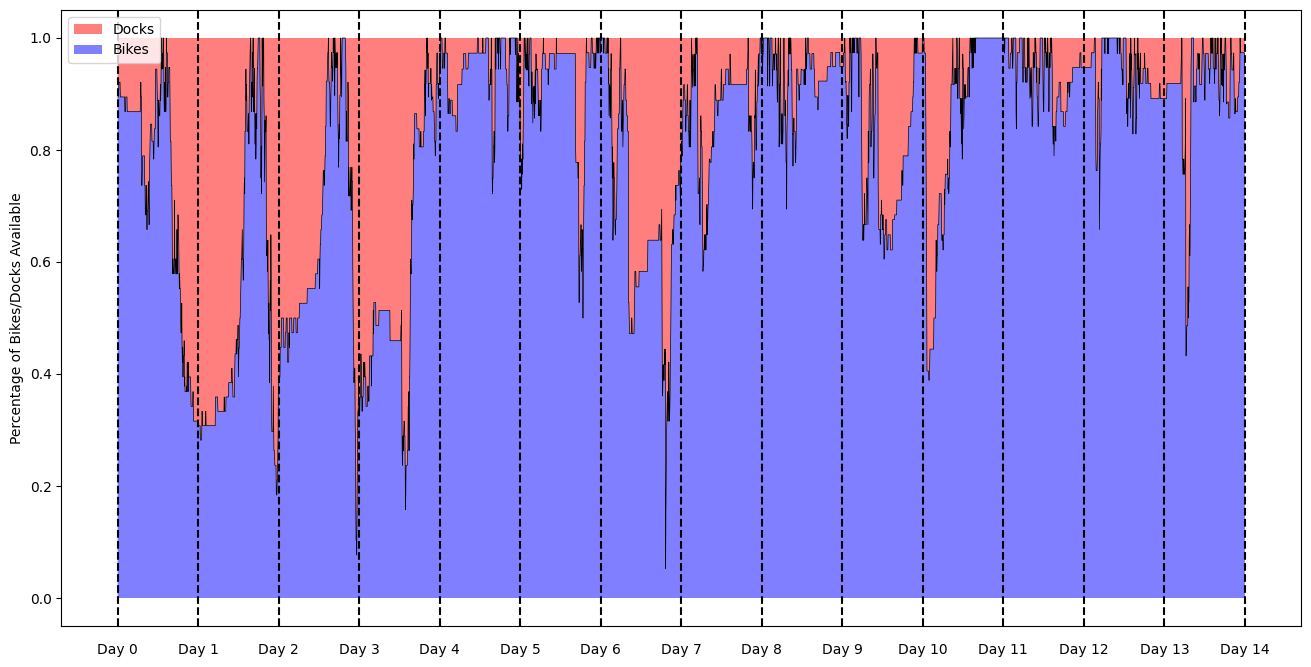

In [ ]:
data = df_ferry[['percentage_bikes_available']].loc["2021-10-01":"2021-10-14 00:00:00"]
x = range(len(data))

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(x, data.percentage_bikes_available, color = 'black', linewidth=.5)
ax.fill_between(x,list(data.percentage_bikes_available.values),1, label='Docks', facecolor='red', alpha=.5)
ax.fill_between(x,list(data.percentage_bikes_available.values),0, label='Bikes', facecolor='blue', alpha=.5)

# Place vertical lines at the date positions
days = list(set(data.index.values.astype('datetime64[D]')))
for i, date in enumerate(days):
    x_position = i * (len(x) - 1) / len(days)
    ax.axvline(x_position, color='black', linestyle='--')
    ax.text(x_position, -0.1, f'Day {i}', ha='center')

x_position = len(x) - 1
ax.axvline(x_position, color='black', linestyle='--')
ax.text(x_position, -0.1, f'Day {len(days)}', ha='center')

# Remove x-axis labels
ax.set_xticks([])
ax.set_ylabel('Percentage of Bikes/Docks Available')
ax.legend()
plt.show()

We can see that in this specific station (for the given timeframe) very few times there was low bike availability. Meaning, that if you were going to take the bike from the ferry back home on these two weeks in October, you wouldn't have a problem. But! Most people want to go to the Ferry, and that's why (if we see it the other way around) dock availability is almost always very low. So, it can happen you're rushing to take the Ferry and suddenly you arrive and have to find another station to dock your bike (you could end up losing the ferry!). 

Let's dive even more (3-day timespan):

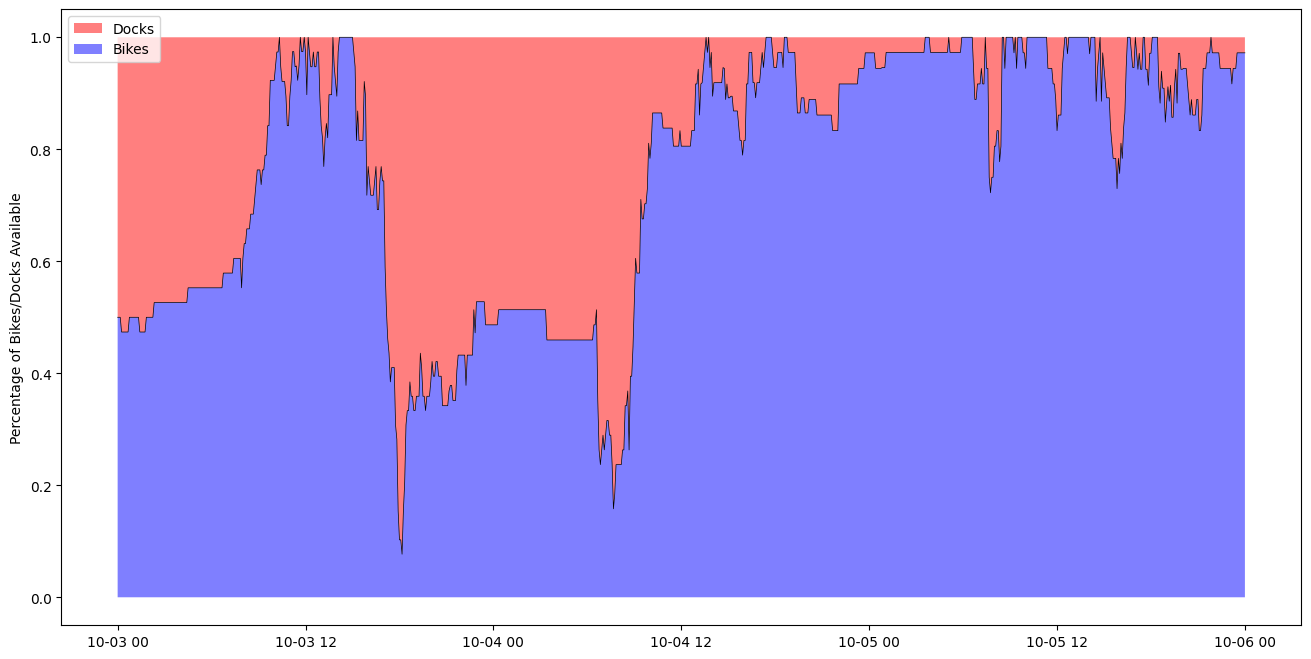

In [ ]:
data = df_ferry[['percentage_bikes_available']].loc["2021-10-03":"2021-10-06 00:00:00"]

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data, color = 'black', linewidth=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),1, label='Docks', facecolor='red', alpha=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),0, label='Bikes', facecolor='blue', alpha=.5)

ax.set_ylabel('Percentage of Bikes/Docks Available')
ax.legend()
plt.show()

In [ ]:
datetime.datetime.strptime("2021-10-03", '%Y-%m-%d').weekday() # Monday - 0, Sunday - 6

6

We have a plot for days Oct 3 (Sunday from 00:00 to 23:59) to Oct 5 (Tuesday from 00:00 to 23:59). We can observe how for Sunday, around noon is when docks start getting filled, which could mean a lot of people are arriving at the station with their bikes (probably to take the ferry). Then, around 6 pm, we have a drop of bike availability (people returning home). Now, for Monday bike availability drops early in the morning (may be people going to the city to work), and then we start having low dock availability for the rest of the day. Let's look at another start of the week Oct 17 (Sunday from 00:00 to 23:59) to Oct 19 (Tuesday from 00:00 to 23:59).

In [ ]:
datetime.datetime.strptime("2021-10-17", '%Y-%m-%d').weekday() # Monday - 0, Sunday - 6

6

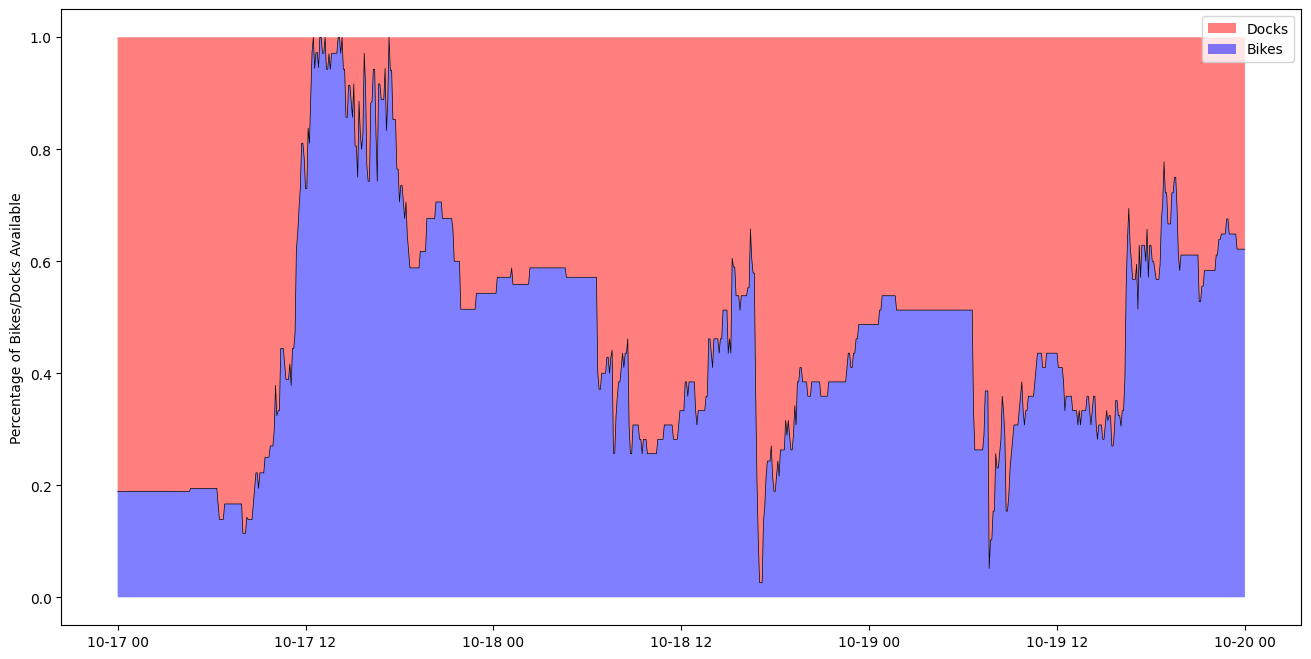

In [ ]:
data = df_ferry[['percentage_bikes_available']].loc["2021-10-17":"2021-10-20 00:00:00"]

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data, color = 'black', linewidth=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),1, label='Docks', facecolor='red', alpha=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),0, label='Bikes', facecolor='blue', alpha=.5)

ax.set_ylabel('Percentage of Bikes/Docks Available')
ax.legend()
plt.show()

We can see a similar pattern repeating on Sunday, but a different pattern on the week, with higher availability of docks (almost balanced with bikes). With this, we give ourselves an idea of how variables such as `is_weekend` or `day_of_the_week` could be valuable for our predictions. 

What happens for other stations as W 25 St & 6 Ave (a station in Flatiron close to a working/office area)?

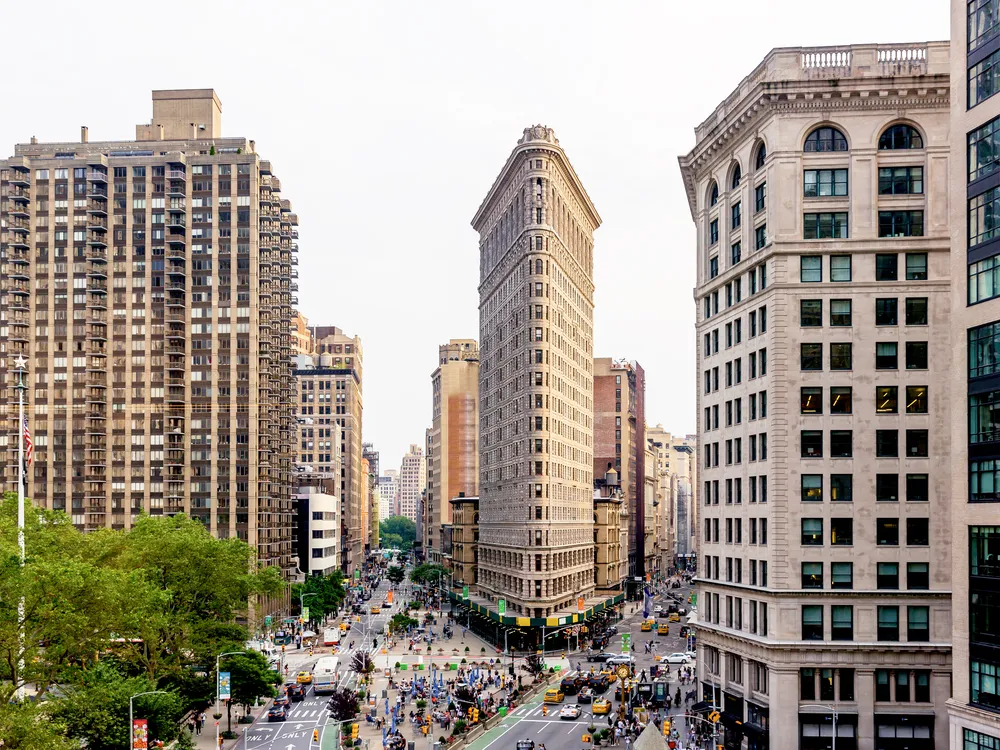

In [ ]:
df_flat = df_ml.query("station_id=='466'").copy()
df_flat = df_flat.set_index("station_status_last_reported").sort_index()

# Format:
df_flat = df_flat.resample("5T").last()
df_flat = df_flat.fillna(method="ffill")

df_flat.head()

,station_id,lat,lon,true_bike_capacity,capacity,percentage_bikes_available
station_status_last_reported,,,,,,
2020-11-30 19:00:00-05:00,466,40.743954,-73.991449,28,35,0.821429
2020-11-30 19:05:00-05:00,466,40.743954,-73.991449,28,35,0.821429
2020-11-30 19:10:00-05:00,466,40.743954,-73.991449,28,35,0.821429
2020-11-30 19:15:00-05:00,466,40.743954,-73.991449,28,35,0.857143
2020-11-30 19:20:00-05:00,466,40.743954,-73.991449,28,35,0.821429


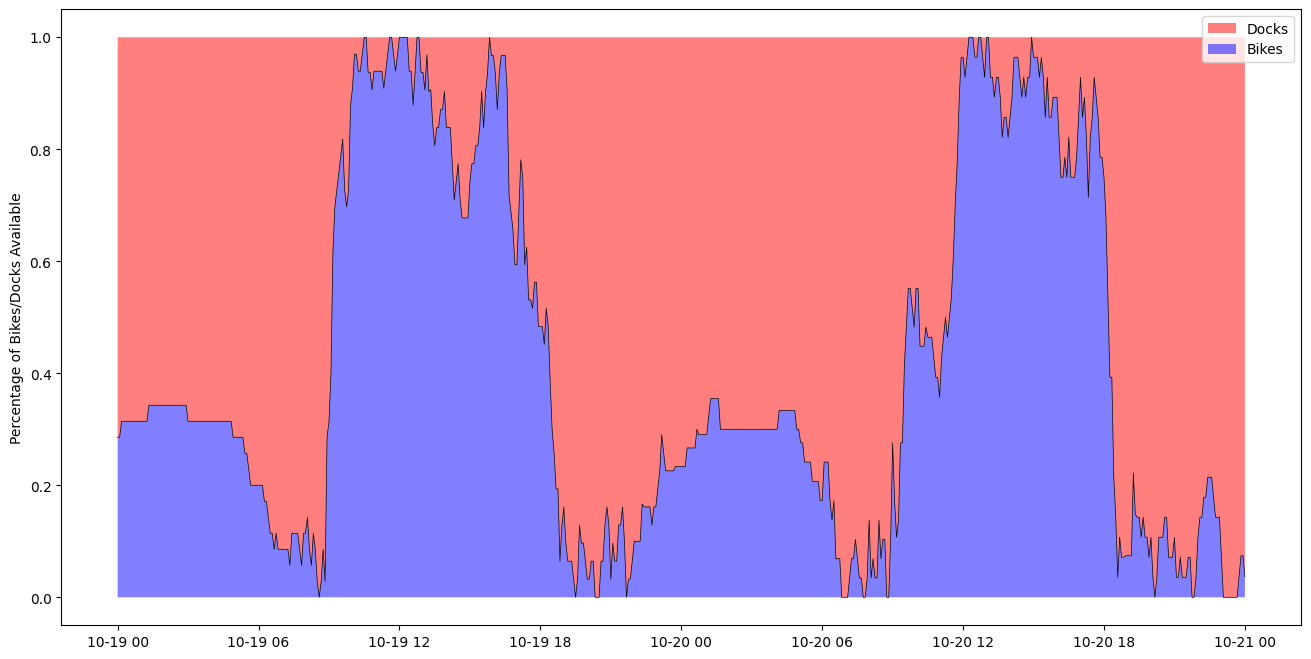

In [ ]:
data = df_flat[['percentage_bikes_available']].loc["2021-10-19":"2021-10-21 00:00:00"]

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data, color = 'black', linewidth=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),1, label='Docks', facecolor='red', alpha=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),0, label='Bikes', facecolor='blue', alpha=.5)

ax.set_ylabel('Percentage of Bikes/Docks Available')
ax.legend()
plt.show()

In [ ]:
datetime.datetime.strptime("2021-10-19", '%Y-%m-%d').weekday() # Monday - 0, Sunday - 6

1

We plotted the data from Tuesday and Wednesday, October 2021 (typical weekday). We can notice how early in the morning (around 7-8 am) all the docks get occupied (everybody arrives to work), and after 6 we see all the bikes are rented! (everybody gets out from out and heads home). And in the weekend? 

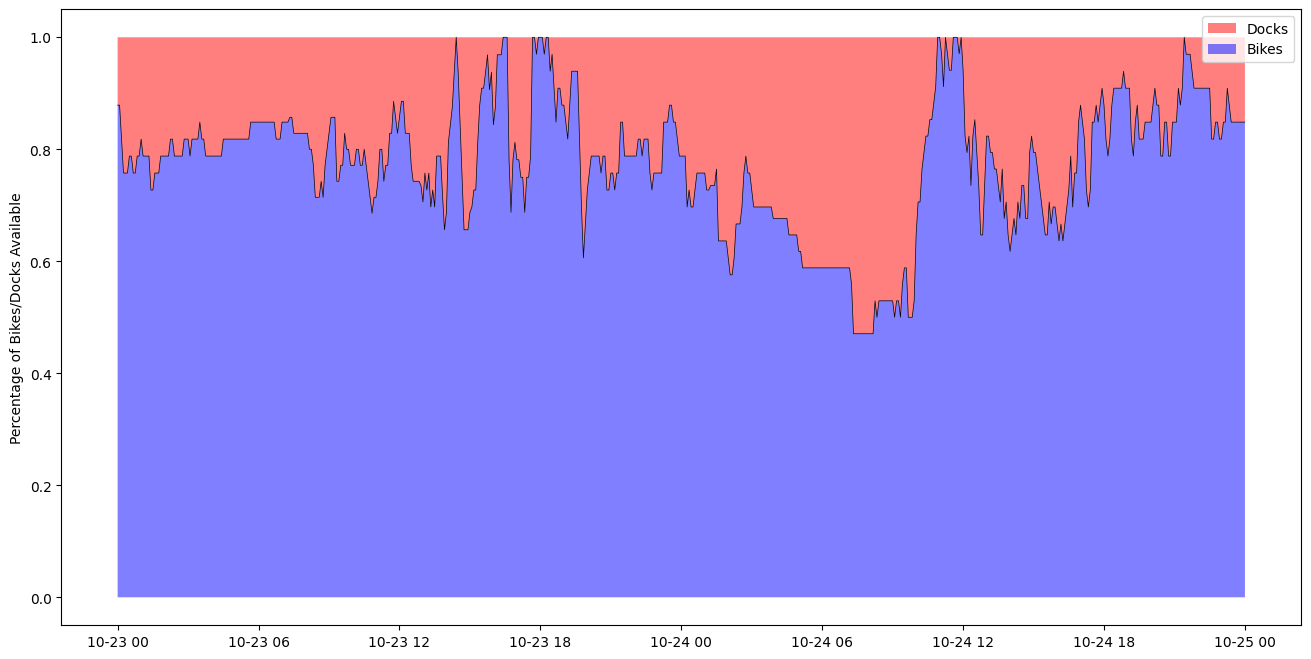

In [ ]:
data = df_flat[['percentage_bikes_available']].loc["2021-10-23":"2021-10-25 00:00:00"]

fig, ax = plt.subplots(figsize=(16, 8))

ax.plot(data, color = 'black', linewidth=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),1, label='Docks', facecolor='red', alpha=.5)
ax.fill_between(data.index.values,list(data.percentage_bikes_available.values),0, label='Bikes', facecolor='blue', alpha=.5)

ax.set_ylabel('Percentage of Bikes/Docks Available')
ax.legend()
plt.show()

Completely different behavior! We don't observe peeks of low-bike availability. What we can observe is that we do have times when there are no docks left. Another example where we think a variable `is_weeday` would be valuable to make availability predictions.

Now, after 

## REFORMAT TIME (ALL STATIONS)

Now, let's reformat all our time variables (5-minute increments between each observation per station):

In [ ]:
# Step 1: Obtain time features
def reformat_time(df, stations):
    # Create an empty list to store DataFrames
    dfs = []
    
    for station_id in stations.station_id.unique():
        df_station = df.query(f"station_id=='{station_id}'").copy()
        df_station = df_station.set_index("station_status_last_reported").sort_index()
        df_station = df_station.resample("5T").last()
        df_station = df_station.fillna(method="ffill")
        dfs.append(df_station)
    
    # Concatenate the DataFrames into one DataFrame
    df_prep = pd.concat(dfs)
    
    return df_prep

In [ ]:
df_prep = reformat_time(df_ml, stations)

In [ ]:
df_prep.index

DatetimeIndex(['2020-11-30 20:55:00-05:00', '2020-11-30 21:00:00-05:00',
               '2020-11-30 21:05:00-05:00', '2020-11-30 21:10:00-05:00',
               '2020-11-30 21:15:00-05:00', '2020-11-30 21:20:00-05:00',
               '2020-11-30 21:25:00-05:00', '2020-11-30 21:30:00-05:00',
               '2020-11-30 21:35:00-05:00', '2020-11-30 21:40:00-05:00',
               ...
               '2021-11-30 18:10:00-05:00', '2021-11-30 18:15:00-05:00',
               '2021-11-30 18:20:00-05:00', '2021-11-30 18:25:00-05:00',
               '2021-11-30 18:30:00-05:00', '2021-11-30 18:35:00-05:00',
               '2021-11-30 18:40:00-05:00', '2021-11-30 18:45:00-05:00',
               '2021-11-30 18:50:00-05:00', '2021-11-30 18:55:00-05:00'],
              dtype='datetime64[s, US/Eastern]', name='station_status_last_reported', length=1155610, freq=None)

And lastly, creating new features that will help us make the predictions (just as we saw with weekday/weekend):

In [ ]:
# Step 2: Obtain time features
def extract_time_features(df):
    df['dayofweek'] = df.index.dayofweek
    df['weekend'] = np.where(df.index.weekday > 5, 1, 0)
    df['dayofmonth'] = df.index.day
    df['dayofyear'] = df.index.dayofyear
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['hour'] = df.index.hour
    df['minute'] = df.index.minute

    # Holidays (can also help!)
    us_holidays = holidays.US(years=range(2010, 2030)) 
    df["is_holiday"] = df.index.to_series().apply(lambda x: 1 if x in us_holidays else 0)
    return df

In [ ]:
df_prep = extract_time_features(df_prep)
df_prep.head()

,station_id,lat,lon,true_bike_capacity,capacity,percentage_bikes_available,dayofweek,weekend,dayofmonth,dayofyear,month,year,hour,minute,is_holiday
station_status_last_reported,,,,,,,,,,,,,,,
2020-11-30 20:55:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,20,55,0
2020-11-30 21:00:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,0,0
2020-11-30 21:05:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,5,0
2020-11-30 21:10:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,10,0
2020-11-30 21:15:00-05:00,259,40.701221,-74.012342,39,39,0.948718,0,0,30,335,11,2020,21,15,0


In [ ]:
df_prep.to_pickle("../data/data_prep.pkl")

We will also save individually one of our station datasets:

In [ ]:
df_prep_flat = df_prep.query("station_id=='466'").copy()
df_prep_flat.to_pickle("../data/data_prep_flat.pkl")

## Extra Viz

Some extra visualization to see if bike availability varies according to some of our time variables:

In [ ]:
numerical = ['lat', 'lon', 'capacity', 'dayofweek', 'dayofmonth', 'dayofyear', 'month', 'hour', 'minute']
categorical = ['station_id', 'year', 'is_holiday']
label = 'percentage_bikes_available'

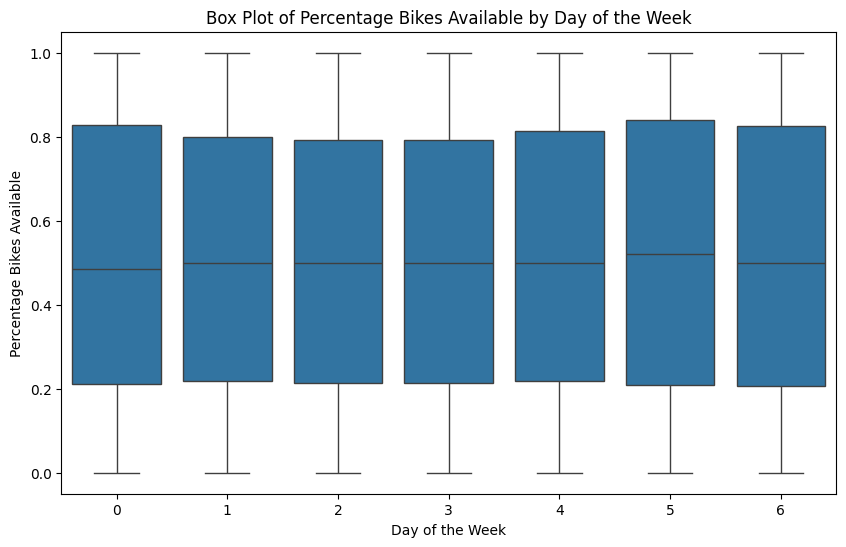

In [ ]:
# Create a box plot of the label column for each day of the week
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_prep, x='dayofweek', y='percentage_bikes_available')
plt.title('Box Plot of Percentage Bikes Available by Day of the Week')
plt.xlabel('Day of the Week')
plt.ylabel('Percentage Bikes Available')
plt.show()

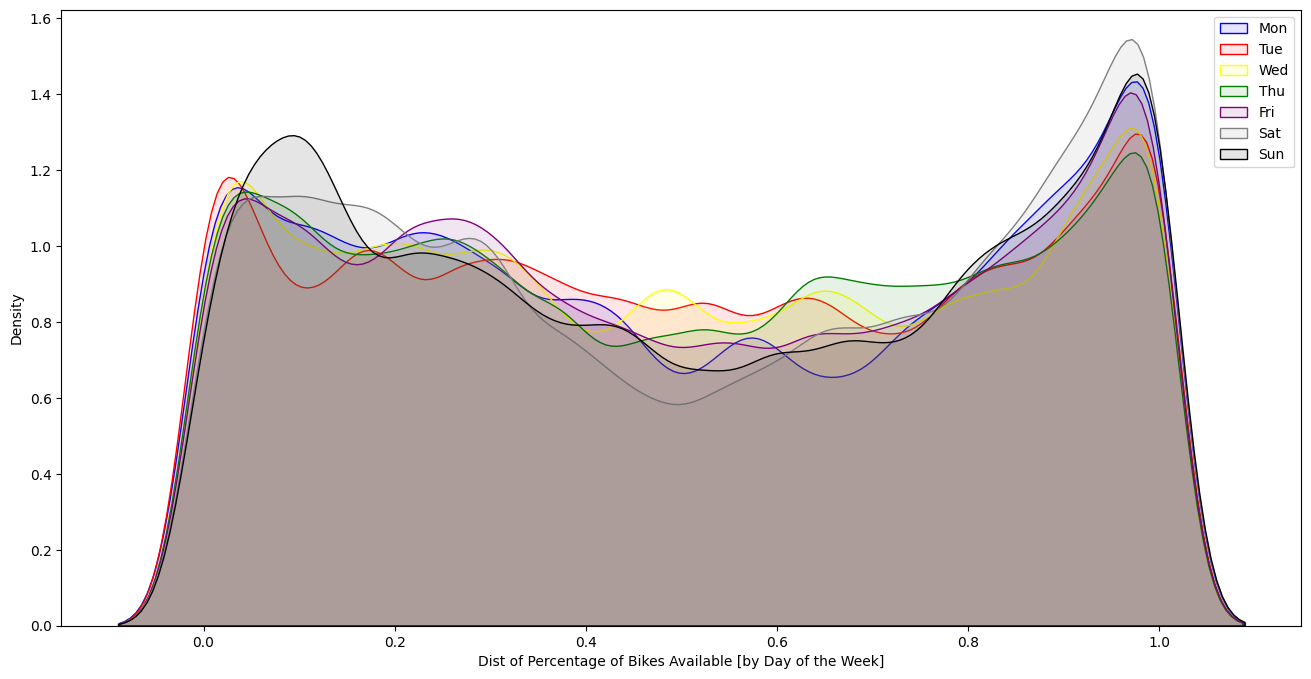

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

sns.kdeplot(df_prep[df_prep.dayofweek==0].percentage_bikes_available, shade=True, color='blue', label='Mon', ax=axs, alpha=.1)
sns.kdeplot(df_prep[df_prep.dayofweek==1].percentage_bikes_available, shade=True, color='red', label='Tue', ax=axs, alpha=.1)
sns.kdeplot(df_prep[df_prep.dayofweek==2].percentage_bikes_available, shade=True, color='yellow', label='Wed', ax=axs, alpha=.1)
sns.kdeplot(df_prep[df_prep.dayofweek==3].percentage_bikes_available, shade=True, color='green', label='Thu', ax=axs, alpha=.1)
sns.kdeplot(df_prep[df_prep.dayofweek==4].percentage_bikes_available, shade=True, color='purple', label='Fri', ax=axs, alpha=.1)
sns.kdeplot(df_prep[df_prep.dayofweek==5].percentage_bikes_available, shade=True, color='gray', label='Sat', ax=axs, alpha=.1)
sns.kdeplot(df_prep[df_prep.dayofweek==6].percentage_bikes_available, shade=True, color='black', label='Sun', ax=axs, alpha=.1)


axs.set_xlabel('Dist of Percentage of Bikes Available [by Day of the Week]')
axs.set_ylabel('Density')
axs.legend()

plt.show()

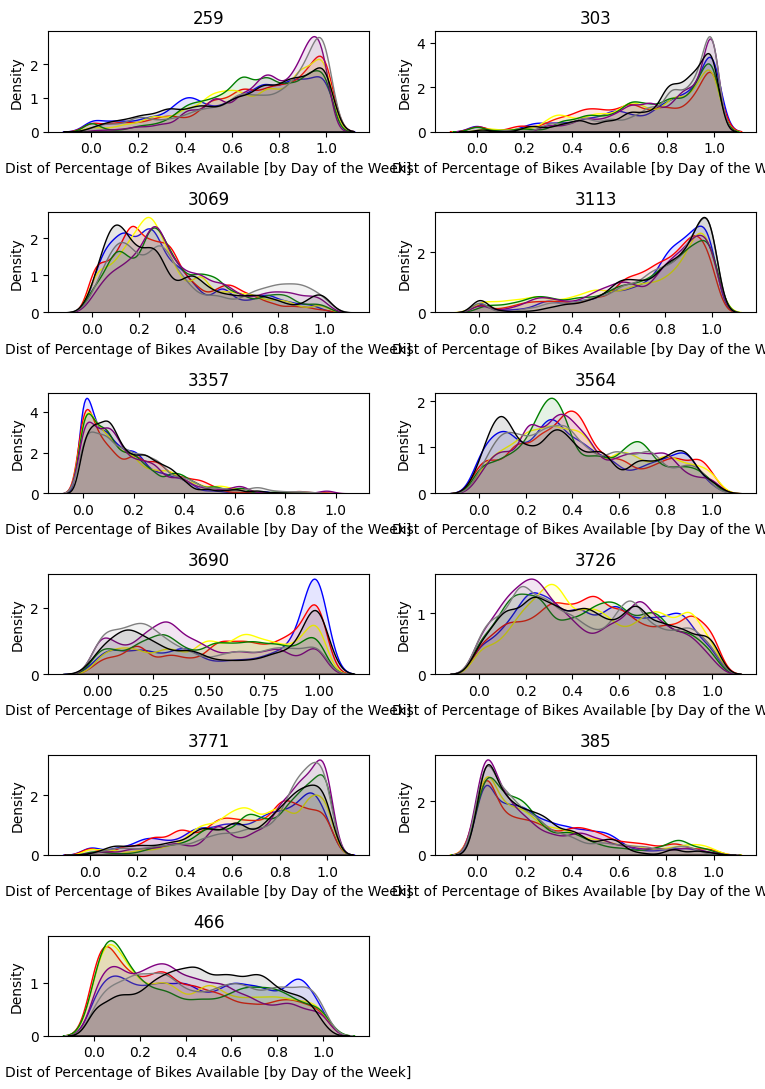

In [ ]:
# Create a figure with multiple subplots in a row
num_rows = len(stations.station_name)
num_cols = 2  # Two columns for side-by-side plots
fig, axs = plt.subplots(math.ceil(num_rows/2), num_cols, figsize=(8, 1 * num_rows))

# Loop through each station_name and create a histogram
for i, station_id in enumerate(stations.station_id):
    row = i // num_cols  # Calculate the row index
    col = i % num_cols   # Calculate the column index

    station_data = df_prep[df_prep['station_id'] == station_id].copy()

    # Create a distribution for the station
    sns.kdeplot(station_data[station_data.dayofweek==0].percentage_bikes_available, shade=True, color='blue', label='Mon', ax=axs[row, col], alpha=.1)
    sns.kdeplot(station_data[station_data.dayofweek==1].percentage_bikes_available, shade=True, color='red', label='Tue', ax=axs[row, col], alpha=.1)
    sns.kdeplot(station_data[station_data.dayofweek==2].percentage_bikes_available, shade=True, color='yellow', label='Wed', ax=axs[row, col], alpha=.1)
    sns.kdeplot(station_data[station_data.dayofweek==3].percentage_bikes_available, shade=True, color='green', label='Thu', ax=axs[row, col], alpha=.1)
    sns.kdeplot(station_data[station_data.dayofweek==4].percentage_bikes_available, shade=True, color='purple', label='Fri', ax=axs[row, col], alpha=.1)
    sns.kdeplot(station_data[station_data.dayofweek==5].percentage_bikes_available, shade=True, color='gray', label='Sat', ax=axs[row, col], alpha=.1)
    sns.kdeplot(station_data[station_data.dayofweek==6].percentage_bikes_available, shade=True, color='black', label='Sun',ax=axs[row, col], alpha=.1)

    # Add titles and Legend
    axs[row, col].set_title(f'{station_id}')
    axs[row, col].set_xlabel('Dist of Percentage of Bikes Available [by Day of the Week]')
    axs[row, col].set_ylabel('Density')

# Adjust the layout and spacing
plt.tight_layout()
fig.delaxes(axs[-1][-1])
# Display the plot
plt.show()

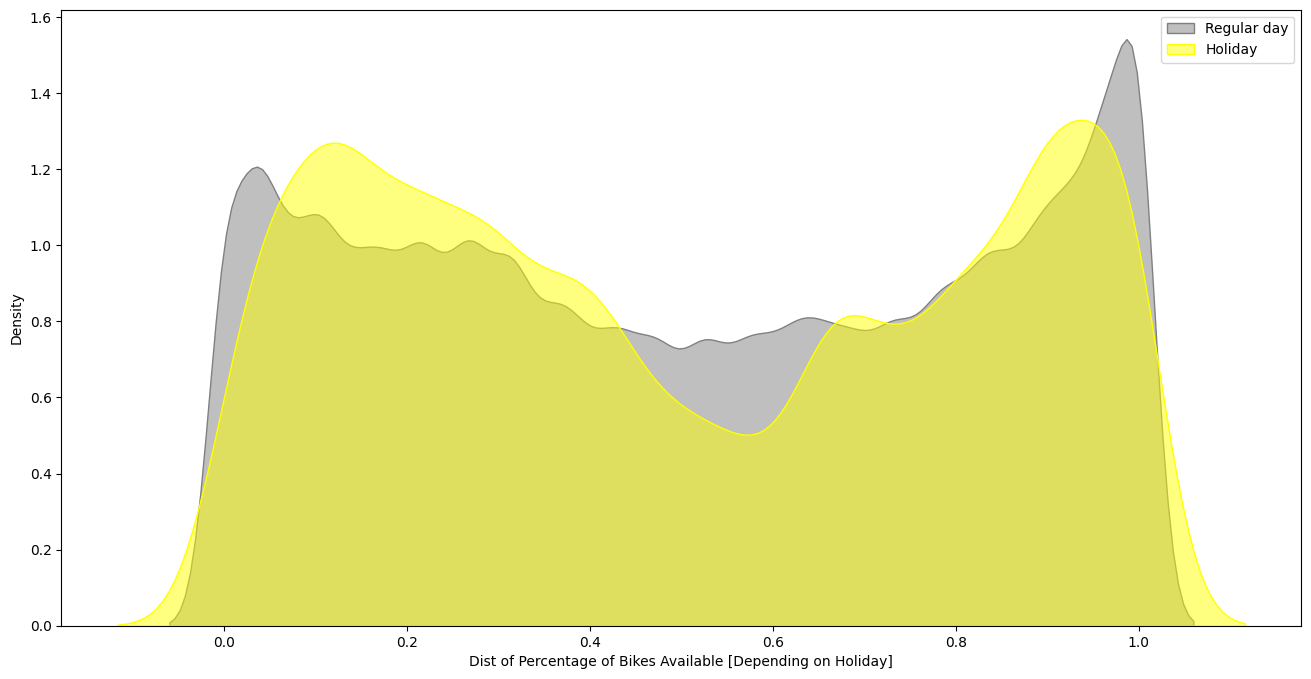

In [ ]:
fig, axs = plt.subplots(1, 1, figsize=(16, 8))

sns.kdeplot(df_prep[df_prep.is_holiday==0].percentage_bikes_available, shade=True, color='gray', label='Regular day', ax=axs, alpha=.5)
sns.kdeplot(df_prep[df_prep.is_holiday==1].percentage_bikes_available, shade=True, color='yellow', label='Holiday', ax=axs, alpha=.5)

axs.set_xlabel('Dist of Percentage of Bikes Available [Depending on Holiday]')
axs.set_ylabel('Density')
axs.legend()

plt.show()